## <b>EDA Process </b>

Load the dataset and explore

In [46]:
import os
import sys
import logging
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import torch
from scipy import signal
import heartpy.filtering

In [2]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


In [3]:
data_files

['mit-bih-normal-sinus-rhythm-database-1.0.0/16265.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16272.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16273.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16420.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16483.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16539.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16773.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16786.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16795.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/17052.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/17453.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/18177.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/18184.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19088.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19090.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19093.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19140.dat',
 'mit-bih-normal-sinus-rhythm-d

In [4]:
names_samples = []
fs = 128
win = 5
fs_new = 128
signal_quality = []

counters = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0,
            16: 0, 17: 0}

In [37]:
## Loop ecg.bin files
part = 0
for participant, file in enumerate(data_files):
    counter = 0

    if participant == part:
        #Get signal
        data = pd.DataFrame({"ECG":wfdb.rdsamp(file[:-4])[0][:,0]})
        data["Participant"] = "MIT-Normal_%.2i" %(participant)
        data["Sample"] = range(len(data))
        data["Sampling_Rate"] = 128
        data["Database"] = "MIT-Normal"

data.head()
    

,ECG,Participant,Sample,Sampling_Rate,Database
0,-0.165,MIT-Normal_00,0,128,MIT-Normal
1,-0.155,MIT-Normal_00,1,128,MIT-Normal
2,-0.195,MIT-Normal_00,2,128,MIT-Normal
3,-0.205,MIT-Normal_00,3,128,MIT-Normal
4,-0.185,MIT-Normal_00,4,128,MIT-Normal


In [38]:
data = data["ECG"].values

In [77]:
ECG_SIGNAL = torch.Tensor(data)
window_complete = ECG_SIGNAL[0:win*fs]

### <b>Data Preprocessing. </b>

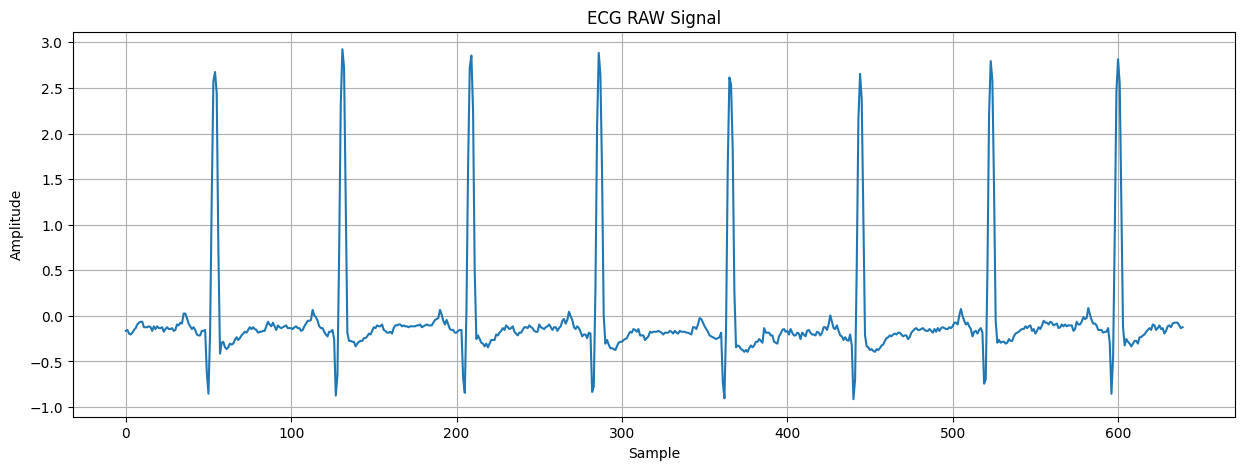

In [78]:
#Plot the signal
plt.figure(figsize=(15, 5))
plt.plot(window_complete)
plt.title("ECG RAW Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

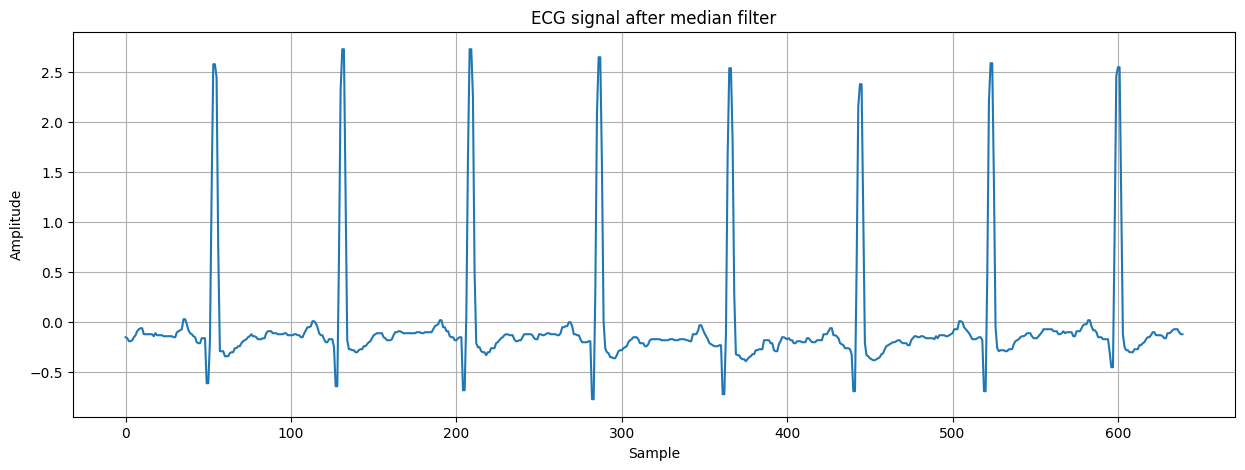

In [79]:
med = signal.medfilt(window_complete, 3)

plt.figure(figsize=(15, 5))
plt.plot(med)
plt.title("ECG signal after median filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

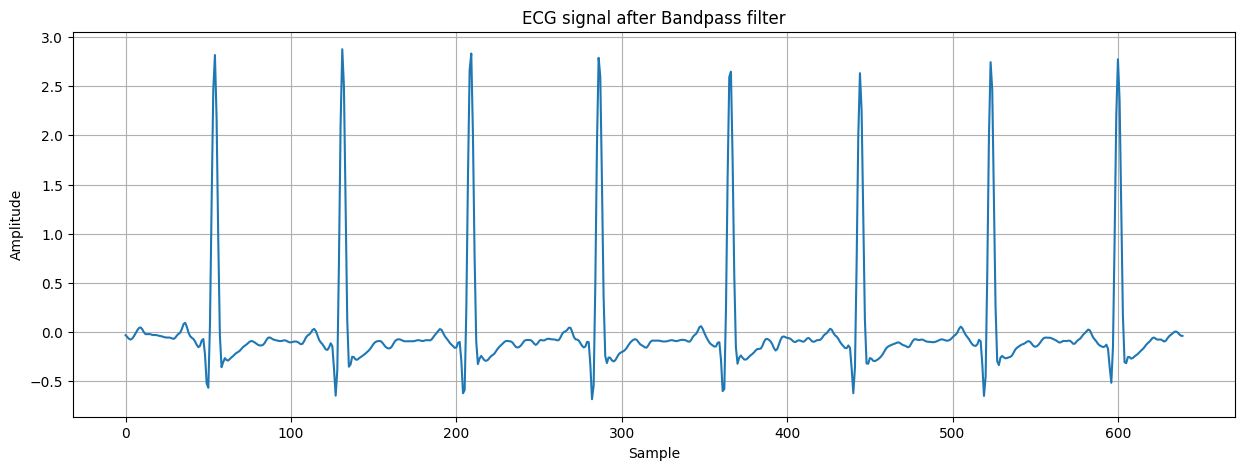

In [80]:
filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                           filtertype='bandpass')

plt.figure(figsize=(15, 5))
plt.plot(filt)
plt.title("ECG signal after Bandpass filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

### <b>Signal quality. </b>
From an ECG segment signal, use pre-trained model to compute
        the quality of the signal. This method is a shortcut to using
        compute_sqi_scores then predict quality.


In [98]:
import numpy as np
from typing import Union
from ecgdetectors import Detectors
import biosppy.signals.ecg as bsp_ecg
from sklearn.preprocessing import StandardScaler

In [ ]:
signal_quality_now = []
win_intra = 1
windows_complete_intra = []

for k in range(win_intra*fs, window_complete.shape[0]+1, win_intra*fs):
    min_limit = k - win_intra*fs
    max_limit = k
    window_complete_intra = filt[min_limit:max_limit]
    windows_complete_intra.append(window_complete_intra)

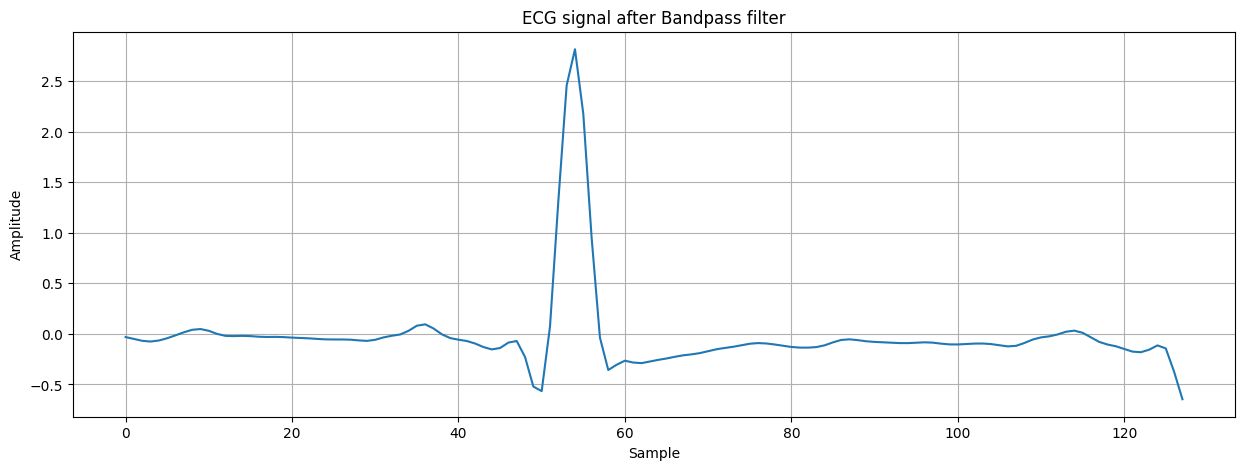

In [97]:
plt.figure(figsize=(15, 5))
plt.plot(windows_complete_intra[0])
plt.title("ECG signal after Bandpass filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

From an ECG Signal segment, computes 6 SQI scores (q_sqi, c_sqi, s_sqi, k_sqi, p_sqi, bas_sqi)

In [93]:
def csqi(ecg_signal: list, sampling_frequency: int) -> float:
    """Variability in the R-R Interval

    When an artifact is present, the QRS detector underperforms by either
    missing R-peaks or erroneously identifying noisy peaks as R- peaks. The
    above two problems will lead to a high degree of variability in the
    distribution of R-R intervals;

    Parameters
    ----------
    ecg_signal : list
        Input ECG signal
    sampling_frequency : list
        Input ecg sampling frequency

    Returns
    -------
    c_sqi_score : float

    """
    with np.errstate(invalid='raise'):

        try:

            rri_list = bsp_ecg.hamilton_segmenter(
                    signal=np.array(ecg_signal),
                    sampling_rate=sampling_frequency)[0]

            c_sqi_score = float(np.round(
                np.std(rri_list, ddof=1) / np.mean(rri_list),
                3))

        except Exception:
            c_sqi_score = 0

        return c_sqi_score

def qsqi(ecg_signal: list, sampling_frequency: int) -> float:
    """Matching Degree of R Peak Detection

    Two R wave detection algorithms are compared with their respective number
    of R waves detected.

    * Hamilton
    * SWT (Stationary Wavelet Transform)

    Parameters
    ----------
    ecg_signal : list
        Input ECG signal
    sampling_frequency : list
        Input ecg sampling frequency

    Returns
    -------
    q_sqi_score : float

    """
    detectors = Detectors(sampling_frequency)
    qrs_frames_swt = detectors.swt_detector(ecg_signal)
    qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
            signal=np.array(ecg_signal),
            sampling_rate=sampling_frequency)[0]

    q_sqi_score = compute_qrs_frames_correlation(qrs_frames_hamilton,
                                                 qrs_frames_swt,
                                                 sampling_frequency)

    return q_sqi_score

def compute_qrs_frames_correlation(qrs_frames_1: list,
                                   qrs_frames_2: list,
                                   sampling_frequency: int,
                                   matching_qrs_frames_tolerance=50) -> float:

    single_frame_duration = 1/sampling_frequency

    frame_tolerance = matching_qrs_frames_tolerance * (
        0.001 / single_frame_duration)

    # Catch complete failed QRS detection
    if (len(qrs_frames_1) == 0 or len(qrs_frames_2) == 0):
        return 0

    i = 0
    j = 0
    matching_frames = 0

    while i < len(qrs_frames_1) and j < len(qrs_frames_2):
        min_qrs_frame = min(qrs_frames_1[i], qrs_frames_2[j])
        # Get missing detected beats intervals

        # Matching frames

        if abs(qrs_frames_2[j] - qrs_frames_1[i]) < frame_tolerance:
            matching_frames += 1
            i += 1
            j += 1
        else:
            # increment first QRS in frame list
            if min_qrs_frame == qrs_frames_1[i]:
                i += 1
            else:
                j += 1

    correlation_coefs = 2 * matching_frames / (len(qrs_frames_1) +
                                               len(qrs_frames_2))

    correlation_coefs = round(correlation_coefs, 3)

    return correlation_coefs

def ssqi(ecg_signal: list) -> float:
    """Computes the skewness sqi.

    Skewness represents how asymetrical a distribution is.

    * Symetrical distribution : skewness = 0
    * Asymetrical distribution skewed on the left : skewness < 0
    * Asymetrical distribution skewed on the right : skewness > 0


    Parameters
    ----------
    ecg_signal : list
        Input ECG signal

    Returns
    -------
    s_sqi_score : float
        rounded skewness sqi score

    """
    num = np.mean((ecg_signal - np.mean(ecg_signal))**3)
    s_sqi = num / (np.std(ecg_signal, ddof=1)**3)
    s_sqi_score = float(round(s_sqi, 3))

    return s_sqi_score

def ksqi(ecg_signal: list) -> float:
    """Computes the excess kurtosis sqi.

    Kurtosis represents how spread a distribution is.

    * Mesokurtic distribution : excess kurtosis = 0
    * Leptokurtic distribution : excess kurtosis > 0
    * Platykurtic distribution : excess kurtosis < 0


    Parameters
    ----------
    ecg_signal : list
        Input ECG signal

    Returns
    -------
    k_sqi_score : float
        rounded excess kurtosis sqi score

    """
    num = np.mean((ecg_signal - np.mean(ecg_signal))**4)
    k_sqi = num / (np.std(ecg_signal, ddof=1)**4)
    k_sqi_fischer = k_sqi - 3.0
    k_sqi_score = float(round(k_sqi_fischer, 3))

    return k_sqi_score

def psqi(ecg_signal: list, sampling_frequency: int) -> float:
    """Computes the power spectrum Distribution of QRS Wave.

    It corresponds to the ratio of the energy of the QRS wave and the energy of
    the ECG signal. The energy of the QRS wave is computed on frequencies
    ranging from 5Hz to 15Hz, the energy of the ECG signal is computed on
    frequencies ranging from 5Hz to 40Hz.

    If interference exists, the high-frequency component increases, and pSQI
    decreases.


    Parameters
    ----------
    ecg_signal : list
        Input ECG signal
    sampling_frequency : list
        Input ecg sampling frequency

    Returns
    -------
    p_sqi_score : float

    """
    n = len(ecg_signal)
    t = 1 / sampling_frequency

    yf = np.fft.fft(ecg_signal)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)

    pds_num = [np.abs(yf[idx]) for idx in range(len(xf)) if
               xf[idx] >= 5 and xf[idx] <= 15]
    pds_denom = [np.abs(yf[idx]) for idx in range(len(xf)) if
                 xf[idx] >= 5 and xf[idx] <= 40]
    p_sqi_score = float(np.round(sum(pds_num) / sum(pds_denom), 3))

    return p_sqi_score


def bassqi(ecg_signal: list, sampling_frequency: int) -> float:
    """Computes the relative power in the Baseline.

    It corresponds to the ratio of the energy of the QRS wave and the energy of
    the ECG signal. The energy of the baseline is computed on frequencies
    ranging from 0Hz to 1Hz, the energy of the ECG signal is computed on
    frequencies ranging from 0Hz to 40Hz.

    If there is no baseline drift interference, the basSQI value is close to 1.
    An abnormal shift in the baseline causes the bassqi to decrease.


    Parameters
    ----------
    ecg_signal : list
        Input ECG signal
    sampling_frequency : list
        Input ecg sampling frequency

    Returns
    -------
    bas_sqi_score : float

    """
    n = len(ecg_signal)
    t = 1 / sampling_frequency

    yf = np.fft.fft(ecg_signal)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)

    pds_num = [np.abs(yf[idx]) for idx in range(len(xf)) if
               xf[idx] >= 0 and xf[idx] <= 1]
    pds_denom = [np.abs(yf[idx]) for idx in range(len(xf)) if
                 xf[idx] >= 0 and xf[idx] <= 40]

    bas_sqi_score = float(np.round(1 - (sum(pds_num) / sum(pds_denom)), 3))

    return bas_sqi_score

In [99]:
def check_type_ecg(ecg_signal: Union[list, np.ndarray]) -> np.ndarray:
    """Checks the type of the ECG and transforms it in np.ndarry if necessary.

    Parameters
    ----------
    ecg_signal : Union[list, np.ndarray]
        Input ECG signal

    Returns
    -------
    ecg_signal : np.ndarray
        ECG signal in proper np.ndarray format
    """
    try:
        assert isinstance(ecg_signal, np.ndarray)
    except AssertionError:
        if isinstance(ecg_signal, list):
            ecg_signal = np.array(ecg_signal)
        else:
            print('Please input a list or a numpy array')
            exit(1)

    try:
        assert len(ecg_signal.shape) == 1
    except AssertionError:
        print('Please input an ecg_signal with shape (1, ) ')
        exit(1)

    return ecg_signal

Calculate the 6 SQI scores - q_sqi, c_sqi, s_sqi,
        k_sqi, p_sqi, bas_sqi

In [103]:
ecg_signal = check_type_ecg(windows_complete_intra[0])

ecg_signal = StandardScaler().fit_transform(ecg_signal.reshape(-1,1)).reshape(1,-1)[0]

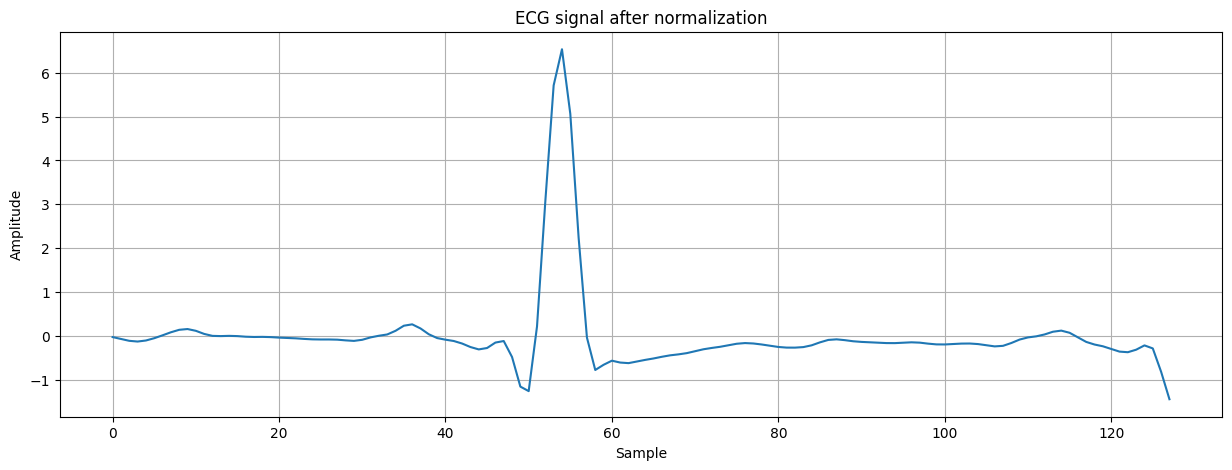

In [105]:
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal)
plt.title("ECG signal after normalization")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

SQI Scores:
q_sqi: 1.0, c_sqi: 0, s_sqi: 4.829, k_sqi: 25.22, p_sqi: 0.601, bas_sqi: 1.0


d:\Campus\4\Research\CODE\Forecasting-for-anomaly-detection-on-ECG\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'SQI Scores')

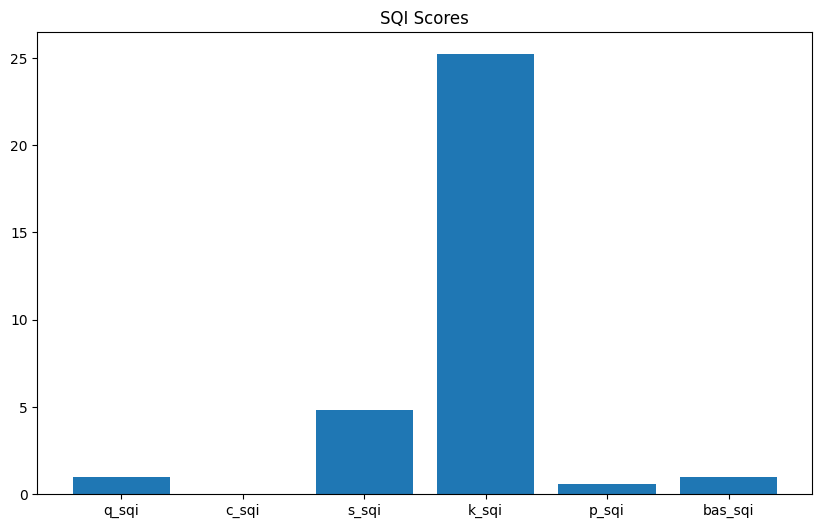

In [106]:
q_sqi_score = qsqi(ecg_signal, fs)
c_sqi_score = csqi(ecg_signal, fs)

s_sqi_score = ssqi(ecg_signal)
k_sqi_score = ksqi(ecg_signal)

p_sqi_score = psqi(ecg_signal, fs)
bas_sqi_score = bassqi(ecg_signal, fs)

sqi_scores = [[q_sqi_score, c_sqi_score, s_sqi_score,
                k_sqi_score, p_sqi_score, bas_sqi_score]]
# Print the SQI scores
print("SQI Scores:")
print(f"q_sqi: {q_sqi_score}, c_sqi: {c_sqi_score}, s_sqi: {s_sqi_score}, "
      f"k_sqi: {k_sqi_score}, p_sqi: {p_sqi_score}, bas_sqi: {bas_sqi_score}")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(['q_sqi', 'c_sqi', 's_sqi', 'k_sqi', 'p_sqi', 'bas_sqi'], sqi_scores[0])
plt.title('SQI Scores')

The quality of an ECG segment, usually lasting several seconds. It computes SQIs (Signal Quality Indicator) and use them in a pre-trained model to predict the quality:

         1 : good quality
         0 : bad quality

In [110]:
from joblib import load
import pickle

In [124]:
def load_model(model_file: str):
    """From an included model name or a model path, checks the format (pkl or
    joblib) and loads it accordingly.

    Parameters
    ----------
    model_file : str
        Path to the model to load or included model filename

    Returns
    -------
    model :
        Sklearn or XGboost model
    """
    _model_included = 'trained_models_quality_check/xgb_9s.joblib'

    if os.path.exists(_model_included):
        model_to_load = _model_included
    else:
        model_to_load = model_file

    model_name = os.path.basename(model_to_load)
    *_, model_extension = model_name.split('.')

    if model_extension == 'joblib':
        ml_model = load(model_to_load)

    elif model_extension == 'pkl':
        with open(model_to_load, 'rb') as file:
            ml_model = pickle.load(file)
    return ml_model

model_file = "xgb_9s.joblib"

model = load_model(model_file)

ModuleNotFoundError: No module named 'xgboost'